.: Apresentação do Problema :.

O hospital quer usar IA para ajudar na triagem inicial de doenças crônicas.

Neste caso, focamos no risco de diabetes, com base em exames laboratoriais simples.

A IA será treinada para prever: "Essa pessoa tem diabetes ou não?" (Classificação Binária)

1. Iremos importar o dataset, realizar uma análise inicial para entender sua estrutura e aplicar os primeiros tratamentos nos dados.

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from collections import Counter
from sklearn.model_selection import (train_test_split, cross_val_score)
from lime import lime_tabular
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score, RocCurveDisplay)


# Carregar o dataset
df = pd.read_csv('diabetes.csv')

# Visualizar as primeiras linhas
print(df.head())

# Verificar informações básicas do dataset
print(df.info())

# Estatísticas descritivas
print(df.describe())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

2. Iremos aprofundar a análise exploratória dos dados. Vamos utilizar gráficos como histogramas e mapas de calor para entender a distribuição das variáveis e a correlação entre elas. Essa etapa é essencial para identificar padrões, outliers e possíveis relações entre os atributos.

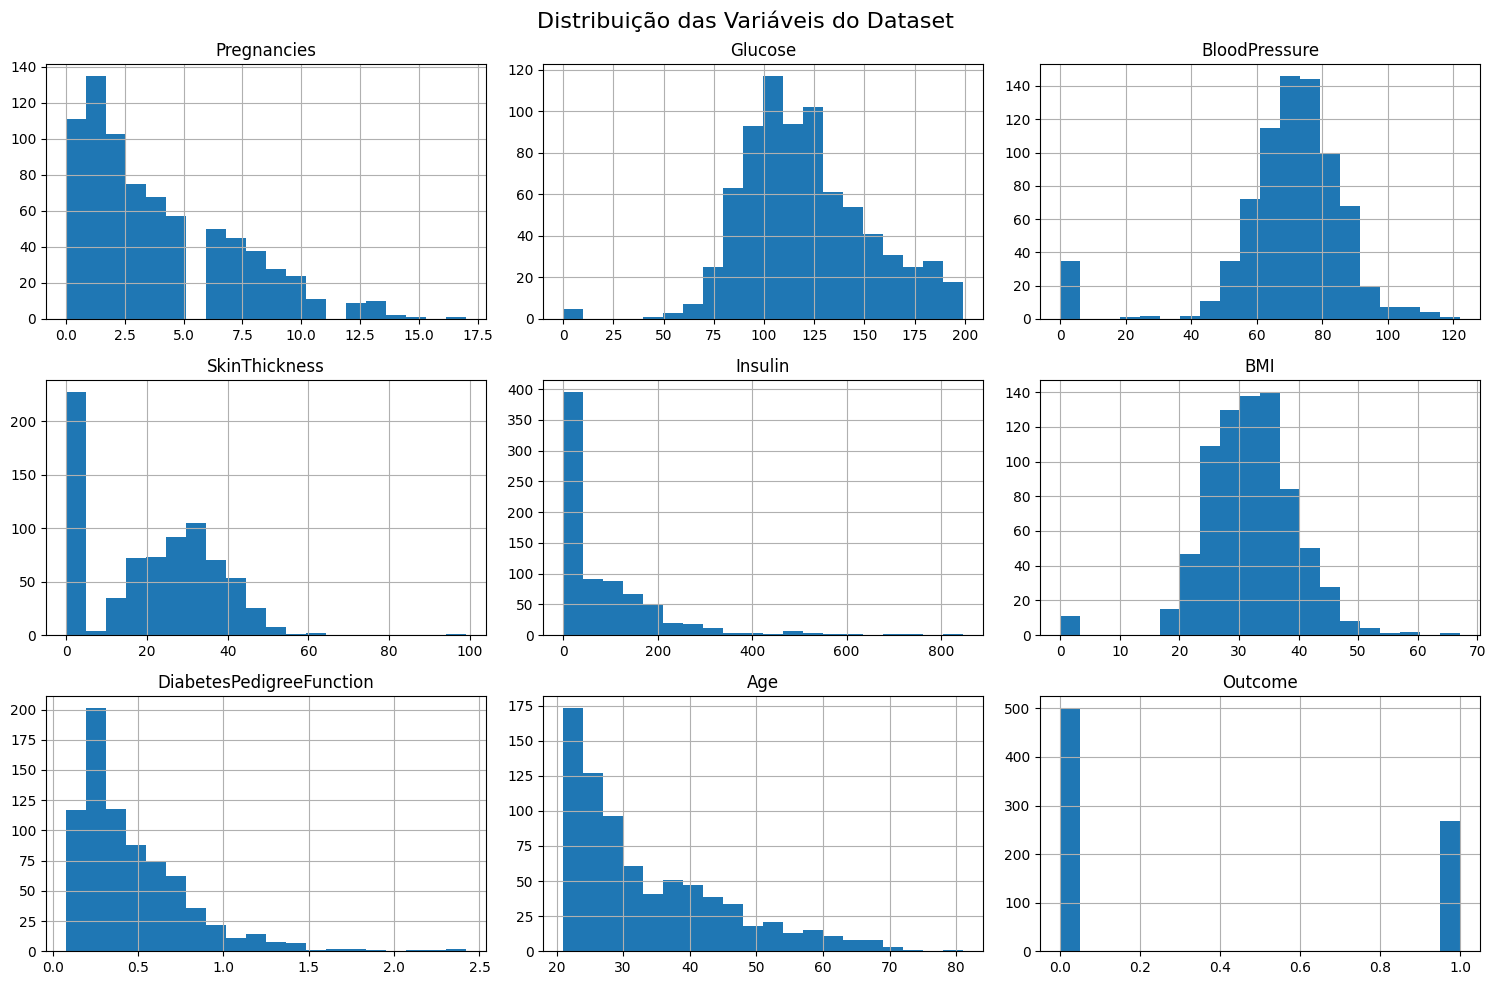

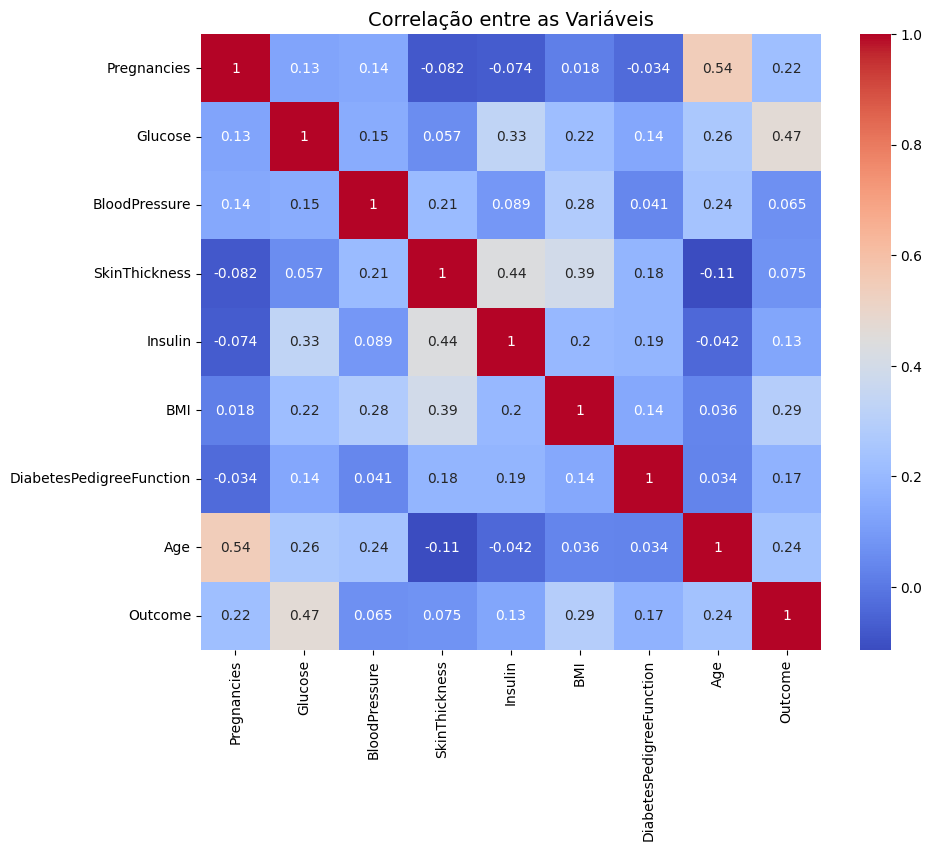

In [175]:
# Criar histogramas para ver a distribuição das variáveis
df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribuição das Variáveis do Dataset', fontsize=16)
plt.tight_layout()
plt.show()

# Criar mapa de calor da correlação
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre as Variáveis', fontsize=14)
plt.show()

Carregamos o conjunto de dados, realizamos uma exploração inicial das variáveis numéricas, analisamos a distribuição dos dados por meio de histogramas e verificamos a correlação entre as variáveis utilizando um mapa de calor. O campo Outcome é a variável-alvo para o treinamento dos modelos, indicando a presença (1) ou ausência (0) de diabetes.

3. Identificamos valores inconsistentes (zero) em variáveis clínicas como glicose, pressão arterial e IMC.

In [176]:
# Verificando a quantidade de zeros nas colunas suspeitas
colunas_problema = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for coluna in colunas_problema:
    print(f'{coluna} - quantidade de zeros: {df[coluna].value_counts().get(0, 0)}')

# Substituindo zeros pela mediana
for coluna in colunas_problema:
    mediana = df[coluna].median()
    df[coluna] = df[coluna].replace(0, mediana)

# Separando as variáveis de entrada e o alvo
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Normalizando os dados
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

print(X_normalizado[:5])  # Apenas para verificar
print(y.value_counts())   # Verificar proporção das classes

Glucose - quantidade de zeros: 5
BloodPressure - quantidade de zeros: 35
SkinThickness - quantidade de zeros: 227
Insulin - quantidade de zeros: 374
BMI - quantidade de zeros: 11
[[ 0.63994726  0.86604475 -0.03198993  0.83111367 -0.60820096  0.16724016
   0.46849198  1.4259954 ]
 [-0.84488505 -1.20506583 -0.5283186   0.1805664  -0.60820096 -0.85155088
  -0.36506078 -0.19067191]
 [ 1.23388019  2.01666174 -0.69376149 -0.46998087 -0.60820096 -1.33183808
   0.60439732 -0.10558415]
 [-0.84488505 -1.07356674 -0.5283186  -0.46998087 -0.00618459 -0.63323851
  -0.92076261 -1.04154944]
 [-1.14185152  0.50442227 -2.67907616  0.83111367  0.69537779  1.54988514
   5.4849091  -0.0204964 ]]
Outcome
0    500
1    268
Name: count, dtype: int64


Substituímos os valores zerados pela mediana da respectiva variável. Em seguida, os dados foram normalizados com o StandardScaler para adequação à modelagem preditiva.


Com os dados tratados, podemos fazer alguns gráficos e observações:

<Axes: xlabel='Insulin', ylabel='Glucose'>

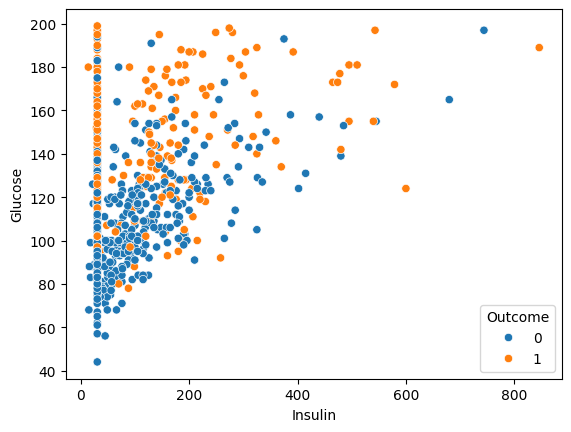

In [177]:
sns.scatterplot(df, y='Glucose', x='Insulin', hue='Outcome')

Conforme o gráfico acima, podemos verificar que a glicose mais baixa possui mais instâncias de diabetes negativo, e que a insulina mais alta faz com que mais casos negativos de diabetes apareçam mesmo com uma glicemia alta.

<Axes: xlabel='Insulin', ylabel='Pregnancies'>

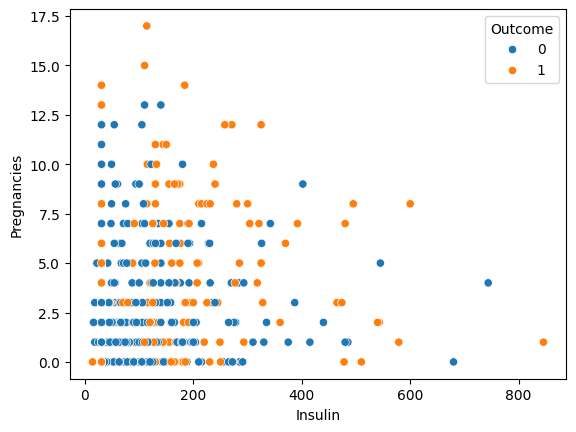

In [178]:
sns.scatterplot(df, y='Pregnancies', x='Insulin', hue='Outcome')

No gráfico acima é demonstrado como os índices de gravidez tornam o índice de insulina volátil. Isso se dá pela variação hormonal que ocorre durante a gravidez.

4.  Iremos realizar a separação dos dados em conjuntos de treino, validação e teste. Em seguida, utilizaremos um modelo base de Regressão Logística para realizar os primeiros experimentos e obter as métricas iniciais de desempenho, que servirão como referência para comparações futuras.

In [179]:
# Separar os dados em treino (70%) e teste (30%)
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X_normalizado, y, test_size=0.3, random_state=42, stratify=y
)

# Criar e treinar o modelo
modelo_lr = LogisticRegression(max_iter=200)
modelo_lr.fit(X_treino, y_treino)

# Fazer previsões
y_pred = modelo_lr.predict(X_teste)

# Avaliar acurácia
print(f"Acurácia: {accuracy_score(y_teste, y_pred):.2f}")

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_teste, y_pred))

# Relatório completo
print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_pred))

Acurácia: 0.75

Matriz de Confusão:
[[130  20]
 [ 37  44]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       150
           1       0.69      0.54      0.61        81

    accuracy                           0.75       231
   macro avg       0.73      0.70      0.71       231
weighted avg       0.75      0.75      0.75       231



A base foi dividida em treino (70%) e teste (30%), mantendo a proporção das classes. O modelo apresentou uma acurácia de 75%, houve um bom equilíbrio entre precision e recall, com destaque para a importância de priorizar o recall em contextos médicos para minimizar falsos negativos, ou seja, evitar deixar de diagnosticar um paciente que realmente tem diabetes.

5. Agora iremos explorar o algoritmo Random Forest para classificar os dados. Trata-se de um modelo mais robusto que combina várias árvores de decisão, visando melhorar a performance e reduzir o overfitting.

Acurácia Random Forest: 0.74

Matriz de Confusão (Random Forest):
[[130  20]
 [ 39  42]]

Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       150
           1       0.68      0.52      0.59        81

    accuracy                           0.74       231
   macro avg       0.72      0.69      0.70       231
weighted avg       0.74      0.74      0.74       231

                   Variável  Importância
1                   Glucose     0.279585
5                       BMI     0.159829
7                       Age     0.123725
6  DiabetesPedigreeFunction     0.115690
0               Pregnancies     0.094344
2             BloodPressure     0.088137
4                   Insulin     0.073901
3             SkinThickness     0.064788


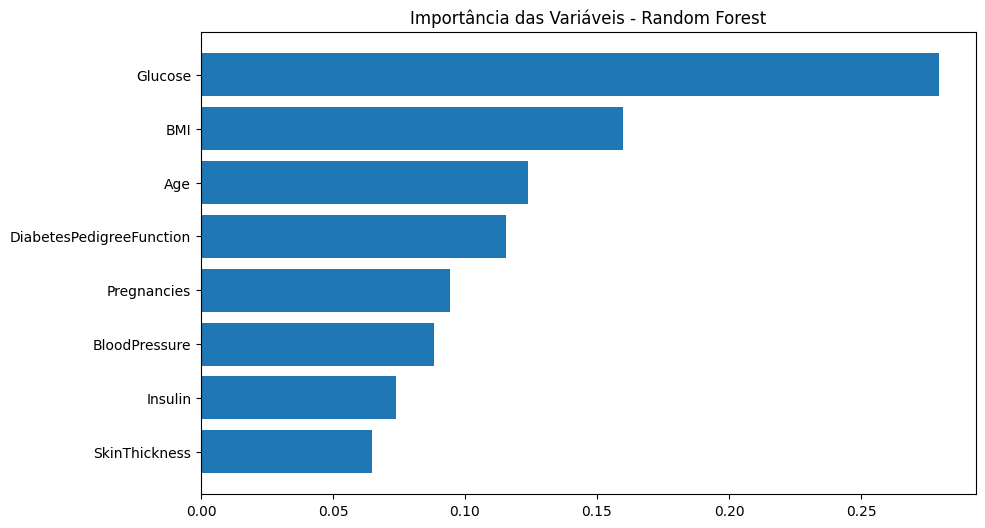

In [180]:
# Criar o modelo Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar o modelo
modelo_rf.fit(X_treino, y_treino)

# Fazer previsões
y_pred_rf = modelo_rf.predict(X_teste)

# Avaliar a acurácia
print(f"Acurácia Random Forest: {accuracy_score(y_teste, y_pred_rf):.2f}")

# Matriz de confusão
print("\nMatriz de Confusão (Random Forest):")
print(confusion_matrix(y_teste, y_pred_rf))

# Relatório completo
print("\nRelatório de Classificação (Random Forest):")
print(classification_report(y_teste, y_pred_rf))

# Importância das variáveis
importancias = modelo_rf.feature_importances_

# Criar um DataFrame para facilitar visualização
colunas = df.drop('Outcome', axis=1).columns
importancia_df = pd.DataFrame({'Variável': colunas, 'Importância': importancias})

# Ordenar do mais importante para o menos
importancia_df = importancia_df.sort_values(by='Importância', ascending=False)

# Exibir
print(importancia_df)

# Gráfico
plt.figure(figsize=(10,6))
plt.barh(importancia_df['Variável'], importancia_df['Importância'])
plt.gca().invert_yaxis()
plt.title('Importância das Variáveis - Random Forest')
plt.show()

O modelo Random Forest apresentou acurácia de 74%. O desempenho na detecção de pacientes sem diabetes foi superior (87% de recall), enquanto na detecção de pacientes com diabetes o recall foi de 52%, evidenciando a dificuldade do modelo em capturar todos os casos positivos. Em cenários clínicos, o recall da classe positiva é essencial, pois perder um diagnóstico real pode ter consequências graves.

6. Nesta etapa, aplicaremos o SMOTE para lidar com o desbalanceamento das classes e melhorar a detecção de casos positivos de diabetes. Avaliaremos o impacto no desempenho do modelo e utilizaremos gráficos comparativos para ilustrar os resultados.

In [181]:
# Criar o SMOTE
smote = SMOTE(random_state=42)

# Aplicar o SMOTE para balancear
X_treino_res, y_treino_res = smote.fit_resample(X_treino, y_treino)

# Ver o novo balanceamento
print('Antes do SMOTE:', y_treino.value_counts())
print('Depois do SMOTE:', pd.Series(y_treino_res).value_counts())

# Treinando novamente a Random Forest com os dados balanceados
modelo_rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf_smote.fit(X_treino_res, y_treino_res)

# Fazendo as previsões no conjunto de teste
y_pred_rf_smote = modelo_rf_smote.predict(X_teste)

print("\nAcurácia Random Forest (com SMOTE):", accuracy_score(y_teste, y_pred_rf_smote))

print("\nMatriz de Confusão (com SMOTE):")
print(confusion_matrix(y_teste, y_pred_rf_smote))

print("\nRelatório de Classificação (com SMOTE):")
print(classification_report(y_teste, y_pred_rf_smote))

Antes do SMOTE: Outcome
0    350
1    187
Name: count, dtype: int64
Depois do SMOTE: Outcome
1    350
0    350
Name: count, dtype: int64

Acurácia Random Forest (com SMOTE): 0.7662337662337663

Matriz de Confusão (com SMOTE):
[[121  29]
 [ 25  56]]

Relatório de Classificação (com SMOTE):
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       150
           1       0.66      0.69      0.67        81

    accuracy                           0.77       231
   macro avg       0.74      0.75      0.75       231
weighted avg       0.77      0.77      0.77       231



Com a aplicação da técnica SMOTE para balanceamento das classes, o modelo Random Forest apresentou melhora considerável na detecção de pacientes com diabetes, elevando o recall da classe positiva de 52% para 69%. Apesar de um pequeno aumento nos falsos positivos, essa abordagem é mais alinhada à área da saúde, onde priorizamos evitar diagnósticos ignorados em detrimento de um pequeno excesso de precaução.

Optamos por avaliar o modelo com recall e F1-score como principais métricas, pois no contexto médico é mais grave não identificar corretamente um paciente com possível diabetes (falso negativo) do que marcar falsamente um saudável. Por isso priorizamos detectar o maior número de casos positivos, mesmo ao custo de aumentar ligeiramente os falsos positivos.

7. Iremos melhorar o desempenho dos modelos usando validação cruzada para garantir a generalização e o GridSearchCV para otimizar os hiperparâmetros. Essas técnicas permitem encontrar a melhor configuração do modelo e evitar overfitting, tornando as previsões mais precisas e confiáveis.

In [182]:
# Usando 5-fold cross-validation com RandomForest
scores = cross_val_score(modelo_rf, X_normalizado, y, cv=5, scoring='accuracy')

print("Acurácias em cada rodada:", scores)
print("Média da acurácia:", scores.mean())

# Definir o modelo base
modelo_base = RandomForestClassifier(random_state=42)

# Grid de parâmetros a testar
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Configurar a busca
grid_search = GridSearchCV(modelo_base, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Rodar a busca
grid_search.fit(X_treino_res, y_treino_res)

# Melhor resultado
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor acurácia na validação cruzada:", grid_search.best_score_)

# Prever com o melhor modelo
modelo_otimizado = grid_search.best_estimator_
y_pred_otimizado = modelo_otimizado.predict(X_teste)

# Avaliar
from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de Confusão:")
print(confusion_matrix(y_teste, y_pred_otimizado))

print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_pred_otimizado))

Acurácias em cada rodada: [0.75974026 0.71428571 0.76623377 0.82352941 0.73856209]
Média da acurácia: 0.7604702487055428
Melhores parâmetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Melhor acurácia na validação cruzada: 0.82
Matriz de Confusão:
[[121  29]
 [ 25  56]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       150
           1       0.66      0.69      0.67        81

    accuracy                           0.77       231
   macro avg       0.74      0.75      0.75       231
weighted avg       0.77      0.77      0.77       231



A aplicação do modelo Random Forest com otimização via GridSearchCV resultou em uma acurácia média de 76% nas validações cruzadas, com pico de 82%. Os melhores hiperparâmetros encontrados foram: n_estimators=100, max_depth=None e min_samples_split=2.

O modelo apresentou boa performance geral, com destaque para a classe 0 (sem diabetes), que obteve precisão de 83% e recall de 81%. Já a classe 1 (com diabetes) teve precisão de 66% e recall de 69%, representando uma melhoria em relação ao modelo anterior.

Em resumo, o ajuste fino dos parâmetros aumentou a robustez do modelo e sua capacidade de generalização, sendo uma abordagem eficaz para detecção de diabetes com dados balanceados.

8. Iremos focar na avaliação gráfica do desempenho dos modelos treinados (Logistic Regression e Random Forest) utilizando a Curva ROC (Receiver Operating Characteristic) e a métrica AUC (Area Under the Curve).
Essas métricas são importantes para avaliar a capacidade de um modelo de distinguir corretamente entre as classes positivas e negativas, independentemente do limiar de decisão adotado.
Além disso, vamos comparar os dois modelos por meio de um único gráfico, tornando a análise visual mais clara e ajudando a escolher o modelo mais adequado para o diagnóstico.

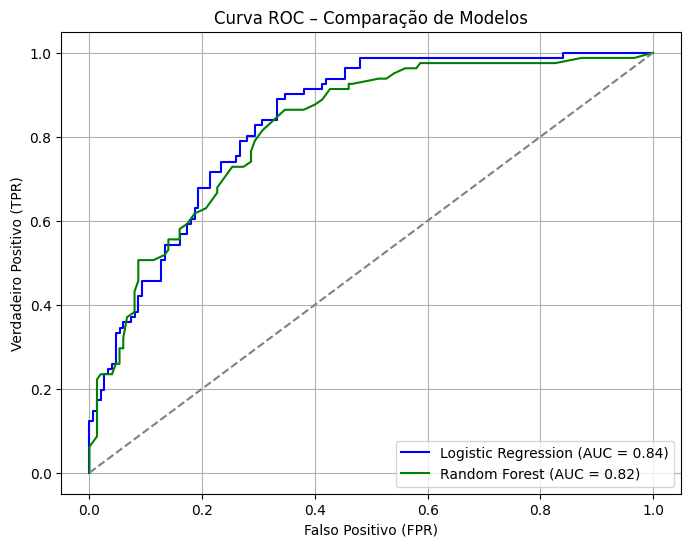

AUC Logistic Regression: 0.838
AUC Random Forest: 0.820


In [183]:
# --- Curva ROC para Logistic Regression ---
y_prob_log = modelo_lr.predict_proba(X_teste)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_teste, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)

# --- Curva ROC para Random Forest ---
y_prob_rf = modelo_rf.predict_proba(X_teste)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_teste, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# --- Plot das Curvas ROC ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='blue', label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # linha de referência
plt.title('Curva ROC – Comparação de Modelos')
plt.xlabel('Falso Positivo (FPR)')
plt.ylabel('Verdadeiro Positivo (TPR)')
plt.legend()
plt.grid(True)
plt.show()

# --- Impressão das AUCs ---
print(f"AUC Logistic Regression: {roc_auc_log:.3f}")
print(f"AUC Random Forest: {roc_auc_rf:.3f}")

Os resultados mostraram que a Logistic Regression apresentou um AUC de 0.838, superior ao AUC de 0.820 obtido pela Random Forest.
Isso indica que, na métrica ROC/AUC, a Logistic Regression possui maior capacidade de diferenciar entre as classes (pacientes com e sem diabetes).
No entanto, ambos os modelos demonstraram desempenho satisfatório, já que ambos possuem AUC > 0.8, o que é considerado bom poder de discriminação.

9. Vamos realizar o ajuste de hiperparâmetros do modelo Random Forest utilizando a técnica de validação cruzada com GridSearchCV. O objetivo é encontrar a combinação ideal de parâmetros que maximize o desempenho do modelo, avaliando a métrica AUC (Área sob a Curva ROC). Para isso, iremos definir uma grade de parâmetros e aplicar o GridSearchCV com validação cruzada estratificada. Ao final, analisaremos os melhores hiperparâmetros e o desempenho obtido no conjunto de teste.

In [184]:
# Divisão entre treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Definição do modelo base
modelo_forest_classifier = RandomForestClassifier(random_state=42)

# Grade de hiperparâmetros para testar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
}

# Definição da validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configuração do GridSearch
grid_search = GridSearchCV(
    estimator=modelo_forest_classifier,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Treinamento com busca em grade
grid_search.fit(X_treino, y_treino)

# Melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor AUC na validação cruzada:", grid_search.best_score_)

# Avaliação no conjunto de teste
modelo_otimizado = grid_search.best_estimator_
y_pred = modelo_otimizado.predict(X_teste)
y_proba = modelo_otimizado.predict_proba(X_teste)[:, 1]

auc = roc_auc_score(y_teste, y_proba)
print("AUC no conjunto de teste:", round(auc, 3))

# Matriz de confusão e relatório
print("\nMatriz de Confusão:")
print(confusion_matrix(y_teste, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_pred))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Melhores parâmetros: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Melhor AUC na validação cruzada: 0.8334606866002214
AUC no conjunto de teste: 0.811

Matriz de Confusão:
[[83 17]
 [24 30]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       100
           1       0.64      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.70       154
weighted avg       0.73      0.73      0.73       154



A otimização dos hiperparâmetros do modelo Random Forest foi realizada com validação cruzada via GridSearchCV, buscando maximizar a AUC. Os melhores parâmetros encontrados foram max_depth = 5, min_samples_split = 5 e n_estimators = 100. O modelo final obteve AUC de 0.811 no conjunto de teste, demonstrando boa capacidade de discriminação. As métricas indicam que o modelo tem bom desempenho para identificar casos negativos, mas apresenta recall moderado para casos positivos, sugerindo a necessidade de atenção para minimizar falsos negativos no uso prático.

10. Neste estágio, iremos avaliar o impacto de diferentes técnicas de balanceamento de classes no desempenho do modelo de classificação para diagnóstico de diabetes. Como o dataset original apresenta desbalanceamento entre as classes (mais pacientes sem a doença do que com a doença), aplicaremos três abordagens: uso dos dados originais sem balanceamento, oversampling com SMOTE e undersampling da classe majoritária. Avaliaremos a performance do modelo Random Forest em cada cenário, utilizando métricas adequadas como a AUC, matriz de confusão e relatório de classificação para comparar os resultados e identificar a melhor estratégia para o problema clínico.

In [185]:
# 3. Dividir em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Função para treinar e avaliar o modelo
def avaliar_modelo(X_tr, y_tr, nome):
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_tr, y_tr)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    print(f"\n Avaliação - {nome}")
    print(f"Distribuição do treino: {Counter(y_tr)}")
    print(f"AUC: {auc:.3f}")
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred))

    return auc

# 5. Sem balanceamento
auc_original = avaliar_modelo(X_train, y_train, "Sem Balanceamento")

# 6. SMOTE (Oversampling)
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
auc_smote = avaliar_modelo(X_train_sm, y_train_sm, "SMOTE")

# 7. Undersampling (reduz classe majoritária)
under = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under.fit_resample(X_train, y_train)
auc_under = avaliar_modelo(X_train_under, y_train_under, "Undersampling")

# 8. Comparação final
print("\n Comparação de AUCs:")
print(f"Sem Balanceamento: {auc_original:.3f}")
print(f"SMOTE:             {auc_smote:.3f}")
print(f"Undersampling:     {auc_under:.3f}")


 Avaliação - Sem Balanceamento
Distribuição do treino: Counter({0: 350, 1: 187})
AUC: 0.819
Matriz de Confusão:
[[129  21]
 [ 39  42]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       150
           1       0.67      0.52      0.58        81

    accuracy                           0.74       231
   macro avg       0.72      0.69      0.70       231
weighted avg       0.73      0.74      0.73       231


 Avaliação - SMOTE
Distribuição do treino: Counter({1: 350, 0: 350})
AUC: 0.839
Matriz de Confusão:
[[121  29]
 [ 28  53]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       150
           1       0.65      0.65      0.65        81

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.75      0.75      0.75       231


 Avaliação - Undersampling
Di

A aplicação das técnicas de balanceamento melhorou significativamente a capacidade do modelo em identificar corretamente os pacientes com diabetes (classe positiva). Enquanto o modelo treinado com dados originais atingiu uma AUC de 0.819 e recall da classe positiva em 52%, as técnicas de SMOTE e undersampling aumentaram a AUC para 0.839 e 0.849, respectivamente, e melhoraram o recall para 65% e aproximadamente 60%. Isso indica que o modelo se torna mais sensível a casos positivos, o que é essencial para minimizar falsos negativos em aplicações médicas. Contudo, o undersampling, apesar de entregar o melhor resultado, reduz o volume de dados usados no treinamento, podendo levar à perda de informações relevantes. Portanto, a escolha entre as técnicas deve ponderar a preservação dos dados e a sensibilidade desejada no diagnóstico.

11. Utilizamos no próximo bloco a técnica de explicabilidade SHAP para analisar os fatores-chave do modelo:

In [190]:
background_data = shap.utils.sample(X_teste, 100)

explainer = shap.KernelExplainer(modelo_otimizado.predict, background_data)

shap_values = explainer.shap_values(X_teste)
print(f"Valores SHAP calculados para {len(X_teste)} instâncias.")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_teste.iloc[0,:])

100%|██████████| 154/154 [00:08<00:00, 17.49it/s]

Valores SHAP calculados para 154 instâncias.


100%|██████████| 154/154 [00:08<00:00, 17.63it/s]


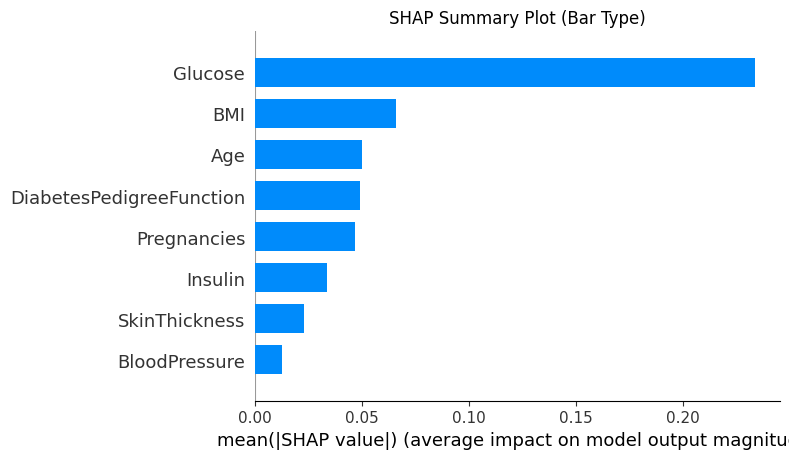

In [191]:
background_data = shap.utils.sample(X_treino, 100)

explainer = shap.KernelExplainer(modelo_otimizado.predict, background_data)

shap_values = explainer.shap_values(X_teste)
if isinstance(shap_values, list):
    # Pega os valores SHAP para a classe positiva (classe 1 para classificação binária)
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values


shap.initjs()
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_to_plot, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (Bar Type)")
plt.tight_layout()

Segundo os dados acima, a glicose é o fator principal para a tomada de decisão, seguido da idade. A glicose é o principal indicador para dizer se uma pessoa possui diabetes ou não, onde um número mais alto sempre vai aumentar a probabilidade de um diagnóstico positivo. Uma idade mais avançada aumenta a probabilidade de diabetes, dado o estilo de vida da pessoa analisada. Conforme esta análise, os fatores indicados pelo modelo fazem sentido para o estudo do caso.

In [ ]:
feature_names = X_treino.columns.tolist()
class_names = ['No Diabetes', 'Diabetes']


explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_treino.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)